In [31]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats

import pandas_datareader as pdr

In [32]:
import pickle
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)
ticker_list_20 = random.sample(list(data.columns), 20)
data = data[ticker_list_20]
ticker_list_20

['TXT.MI',
 'BIA.MI',
 'AMP.MI',
 'ETH.MI',
 'ENAV.MI',
 'DIB.MI',
 'BC.MI',
 'BEST.MI',
 'SFL.MI',
 'B.MI',
 'STM.MI',
 'MARR.MI',
 'ASC.MI',
 'ANIM.MI',
 'BFE.MI',
 'DEA.MI',
 'ELN.MI',
 'RWAY.MI',
 'TIT.MI',
 'SERI.MI']

In [33]:
N = len(ticker_list_20)
n = data.shape[0] - 1
prices = data.values
prices = prices.transpose()
profitability = np.empty((N, n))

for i in range (20):
  for j in range (20):
    profitability[i][j] = math.log(prices[i][j+1]/prices[i][j])
E = np.empty(N)
vars = np.empty(N)   
 
for i in range(N):
  E[i] = statistics.mean(profitability[i])
  vars[i] = math.sqrt(statistics.variance(profitability[i]))

In [34]:
def covarience_matrix(log_returns: pd.DataFrame) -> pd.DataFrame:
    cov_matrix = log_returns.transpose().cov()
    return cov_matrix

profitability_ = pd.DataFrame(profitability, index=ticker_list_20)
cov_matrix = covarience_matrix(profitability_.loc[ticker_list_20])

In [35]:
np.linalg.det(cov_matrix)

3.373700224729082e-100

In [36]:
from cvxopt import matrix, solvers
from scipy.optimize import minimize

def risk_portfolio(X, cov_matrix):
    return np.sqrt(np.dot(np.dot(X, cov_matrix), X.T))
        
def objective_function(X, mean_vec, cov_matrix, b):
    return (-np.dot(mean_vec, X)) + b * np.dot(np.dot(X, cov_matrix), X.T)
    
def optimize_portfolio(mean_vec,
                       cov_matrix, 
                       b, 
                       bounds, 
                       objective_function=objective_function,
                       cvxopt=False):
    if cvxopt:
        r_avg = matrix(mean_vec)
        sigma = matrix(b*cov_matrix)
        n = mean_vec.shape[0]
        P = sigma
        q = matrix(-mean_vec)
        
        G = matrix( -np.identity(n) )
        h = matrix( np.zeros((n,1)) )  
        
        A = matrix(1.0, (1,n))
        d = matrix(1.0)
        sol = solvers.qp(P, q, G, h, A, d, show_progress=False)
        clear_output()
        return np.array([x for x in sol['x']])
    
    else: 
        N = cov_matrix.shape[0]
        X = np.ones(N)
        X = X / X.sum()
        bounds = bounds * N

        constraints=[]
        constraints.append({'type': 'eq', 
                            'fun': lambda X: np.sum(X) - 1.0})

        return minimize(objective_function, X,
                        args=(mean_vec, cov_matrix, b), method='SLSQP',
                        constraints=constraints,
                        bounds=bounds).x

### 1. Истинный оптимальный портфель в модели Марковица с заданным отношением к риску. 

Задана константа b. Решите задачу оптимизации 

- $-E(x)+ b\sigma(x) \rightarrow min,$   
- $x_1+x_2+\cdots+x_N =1$ 
- $x_i \ge 0$
    
(т.е. найдите оптимальный портфель с отношением к риску, равным b). Найдите и зафиксируйте веса портфеля и значение целевой функции. 

Здесь 
- $E(x)= E_1 x_1+E_2 x_2+\cdots+E_N x_N$ , 
- $ \sigma (x)= \sum \sum σ_{ij} x_ix_j$

**Примечание 1.**

Константа b подобрана таким образом, что истинный оптимальный CVaR портфель совпадает с истинным оптимальным портфелем п.1. Значение константы смотри в упражнениях к теме
$$b= \frac{1}{\sqrt{2\pi}}\frac{1}{{1-\beta}}exp(-\frac{(\Phi^{-1}(\beta))^2)}{2})$$

 где $\Phi$ - ф-ция стандартного нормального распределения, а $\beta$ - увeренность для CVaR

In [37]:
beta = 0.95
b = (np.sqrt(2 * np.pi) *(1 - beta) )**(-1) * np.exp(-(stats.norm.ppf(beta)**2 / 2)) 
print('b: ', b)

b:  2.0627128075074257


In [38]:
X = optimize_portfolio(E, cov_matrix, b, bounds=((0, 1),))

<Figure size 800x1400 with 0 Axes>

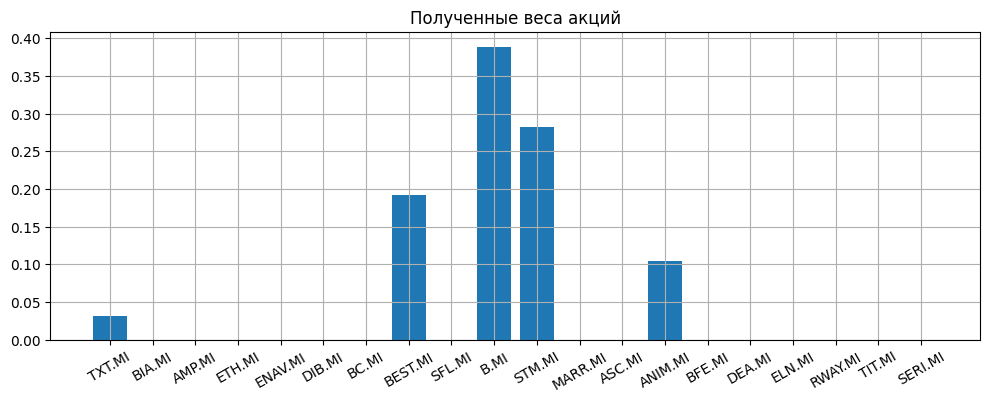

In [39]:
def plot_weights_histogram(weights, ticker_list, name):
    plt.figure(figsize=(8, 14))
    x = ticker_list
    y = weights
    fig, ax = plt.subplots(figsize=(12, 4)) 
    plt.title(name)
    plt.grid()
    ax.bar(x, y)
    plt.xticks(rotation=30)
    plt.show()
    
plot_weights_histogram(X, ticker_list_20, name="Полученные веса акций")

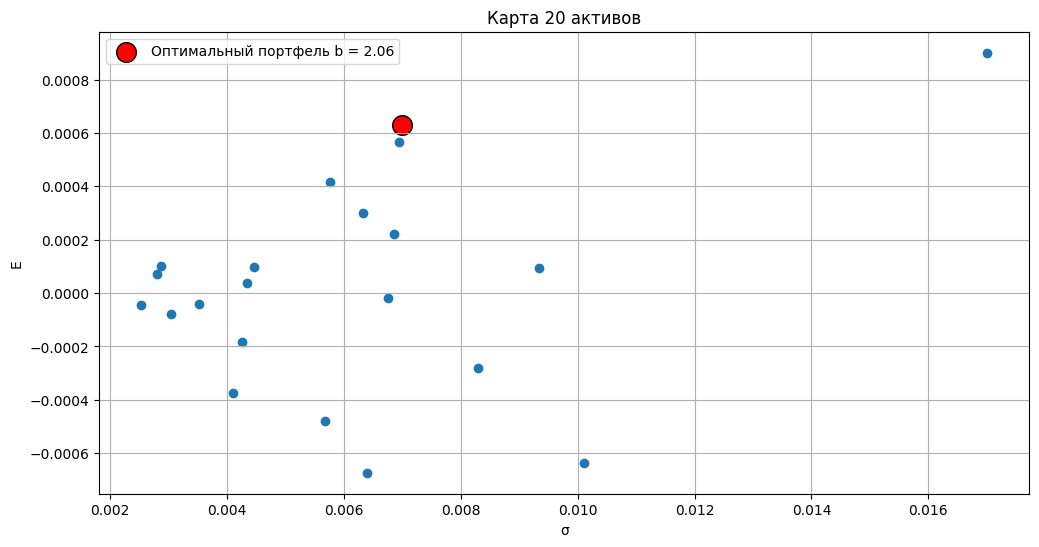

In [45]:
plt.figure(figsize=(12, 6))
plt.xlabel('σ')
plt.ylabel('E')
plt.grid(True)
plt.title("Карта 20 активов")
plt.scatter(vars, E)
plt.scatter(risk_portfolio(X, cov_matrix), np.dot(E,X), c='red',s=200, edgecolors='black', label='Оптимальный портфель b = %.2f' % b)
plt.legend()

plt.show()

### 2. Оценка неопределенности оптимального портфеля в модели Марковица с заданным отношением к риску. 


**2.1 Задайте число наблюдений T=30. С помощью генератора многомерного нормального распределения создайте выборку размера Т из нормального распределения с вектором математических ожиданий  E=(E1, E2, …, EN) и матрицей ковариаций (σi,j).** 

In [46]:
T = 30
r_matrix_gen = np.random.multivariate_normal(E, cov_matrix, T)
r_matrix_gen.shape

(30, 20)

**2.2. По построенной выборке сделайте оценку $E^{est}$ вектора математических ожиданий и оценку $ \sigma ^{est}$ матрицы ковариаций.**

**2.3 Используя эти оценки решите задачу оптимизации**

- $-E^{est}(x)+ b\sigma^{est}(x) \rightarrow min,$  
- $x_1+x_2+\cdots+x_N =1$ 
- $x_i \ge 0$

Здесь $E^{est}(x)= E^{est}_1 x_1+E^{est}_2 x_2+\cdots+E^{est}_N x_N$ , $ \sigma^{est} (x)= \sum \sum σ^{est}_{ij} x_ix_j$

(т.е. найдите выборочный оптимальный портфель с отношением к риску, равным b). Найдите и зафиксируйте веса портфеля и значение целевой функции.

**2.4 Сравните два портфеля: истинный (п.1) и выборочный (п.2.3).**

Оцените относительную ошибку в определении весов портфеля в норме Manhattan (L1 норма Минковского). Сделайте выводы. Сделайте сравнение в системе координат (σ, E).

**2.5. Повторите эксперимент S=40 раз и оцените среднюю относительную ошибку по S повторениям эксперимента.**

Сделайте выводы.  

Сделайте сравнение в системе координат (σ, E). 

**2.6  Предположите, что нам известны точные значения математических ожиданий E=(E1, E2, …, EN).**

Повторите пп. 2.2-2.5. используя оценку только матрицы ковариаций (т.е. решайте задачу оптимизации 

- $-E^{est}(x)+ b\sigma^{est}(x) \rightarrow min,$  
- $x_1+x_2+\cdots+x_N =1$ 
- $x_i \ge 0$

Здесь $E^{est}(x)= E^{est}_1 x_1+E^{est}_2 x_2+\cdots+E^{est}_N x_N$ , $ \sigma^{est} (x)= \sum \sum σ^{est}_{ij} x_ix_j$


Сравните точность этих портфелей и портфелей п.2.3

### 3. Оценка неопределенности оптимального CVaR портфеля 

**3.1 Уровень значимости β выбран 0,95. Число наблюдений T.**

Используя сгенерированные наблюдения из п.2.1 решите задачу ЛП для определения оптимального CVaRβ портфеля.  Найдите и зафиксируйте веса портфеля и значение целевой функции CVaR.  

**3.2 Сравните два портфеля: истинный (п.1) и найденный в п.3.1.**  
    
Оцените относительную ошибку в определении весов портфеля в норме Manhattan (L1 норма Минковского). Сравните с ошибкой портфеля из п. 2.3

**3.3. Повторите эксперимент S раз и оцените среднюю относительную ошибку по S повторениям эксперимента.** 

Сделайте выводы.  Сравните с ошибкой из п. 2.5 